In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time

### 시드 고정

In [2]:
random.seed(333)
np.random.seed(333)

### csv 파일 불러오기

In [3]:
train_data = pd.read_csv('./data/mnist_train.csv')
test_data = pd.read_csv("./data/mnist_test.csv")

### Raw Data 확인

In [4]:
print("mnist_train.csv")
print(train_data.head(10), train_data.shape)
print("\nmnist_test.csv")
print(test_data.head(10), test_data.shape)

mnist_train.csv
   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   
5      2    0    0    0    0    0    0    0    0    0  ...      0      0   
6      1    0    0    0    0    0    0    0    0    0  ...      0      0   
7      3    0    0    0    0    0    0    0    0    0  ...      0      0   
8      1    0    0    0    0    0    0    0    0    0  ...      0      0   
9      4    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0     

### 데이터 프레임 data 추출 및 입력 데이터 정규화
- rgb 값은 0 - 255까지의 값을 가지므로, 255로 나누어 0 - 1 사이로 정규화

In [5]:
# train data
y_train = train_data['label'].values
X_train = train_data.drop(columns=['label']).values/255
# test data
y_test= test_data['label'].values
X_test = test_data.drop(columns=['label']).values/255

### Validation Set 생성

In [6]:
# 전체 train 데이터의 인덱스 리스트 생성
train_indices = list(range(len(X_train)))

# train 데이터 셔플
random.shuffle(train_indices)

# validation set 인덱스 선택
validation_indices = train_indices[:5000]

# validation set 생성
X_validation = np.array([X_train[i] for i in validation_indices])
y_validation = np.array([y_train[i] for i in validation_indices])

# train set 인덱스 선택
train_indices = train_indices[5000:]

# train set 생성
X_train = np.array([X_train[i] for i in train_indices])
y_train = np.array([y_train[i] for i in train_indices])

### Data 확인

In [7]:
print("y_train data :", y_train, y_train.shape)
print("X_train data :", X_train, X_train.shape)
print("\ny_validation data :", y_validation, y_validation.shape)
print("X_validation data :", X_validation, X_validation.shape)
print("\ny_test data :", y_test, y_test.shape)
print("X_test data :", X_test, X_test.shape)

y_train data : [5 2 9 ... 8 2 5] (55000,)
X_train data : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (55000, 784)

y_validation data : [9 1 0 ... 8 3 2] (5000,)
X_validation data : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (5000, 784)

y_test data : [7 2 1 ... 4 5 6] (10000,)
X_test data : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (10000, 784)


### 이미지 확인

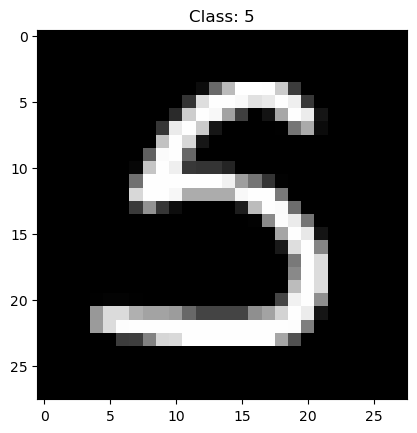

In [8]:
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title('Class: ' + str(y_train[0].item()))
plt.show()

## ReLU 함수

In [9]:
def relu(x):
    x[x<0]=0
    return x

## Sigmoid 함수

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## MSE 함수
- 아웃풋 데이터에 대한 원-핫 인코딩 과정 포함

In [11]:
def mse(y_pred, y_true):
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(10)) # 원-핫 인코딩
    loss_sample = np.mean((y_pred - y_true) ** 2, axis=1)
    return loss_sample

## SoftMax 함수

In [12]:
def softmax(X_in,weights):    
    s = np.exp(np.matmul(X_in,weights)) # 행렬곱 수행
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

## CrossEntropy 함수
- 아웃풋 데이터에 대한 원-핫 인코딩 과정 포함

In [13]:
def loss(y_pred,y_true):
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(10)) # 원-핫 인코딩
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)

    return -np.mean(loss_sample)

# 
# 
# 3-layer ReLU Model (hidden 256)

In [14]:
def relu_modle1(X,W,b):
    # 입력층
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0] # W[0]는 입력층과 은닉층 사이의 가중치 및 노드, b[0]는 은닉층 편향
    
    # 은닉층
    a2 = relu(z1)
    z2 = np.matmul(a2, W[1]) # W[1]은 은닉층과 출력층 사이의 가중치 및 노드
    
    # 출력층 - SoftMax 함수 수행
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    y_hat = s/total

    return y_hat

## 3-layer ReLu Model Error Backpropergation

### 출력층과 은닉층의 연결강도 갱신(Jacobian matrix)
$
\Delta W_{kj}(n+1)=\eta \delta_{pk}O_{pj}+\alpha \Delta W_{kj}(n)
$
### 은닉층과 입력층의 연결강도 갱신
$
\Delta W_{ji}(n+1)=\eta \delta_{pj}O_{pi}+\alpha \Delta W_{ji}(n)
$
#### delta pj에 대한 고찰
$
\delta_{pj}=f_j^{'}(net_{pj})\sum_{k}{\delta_{pk}W_{kj}}
$
- ReLU 함수 이므로 미분시 0보다 크면 1, 아니면 0로 된다.

In [15]:
def backprop(W,b,X,y,alpha=1e-4):
    # 입력층
    a1 = X # O pi
    z1 = np.matmul(X, W[0]) + b[0]
    
    # 은닉층
    a2 = relu(z1) # O pj
    z2 = np.matmul(a2, W[1])
    
    # 출력층 - SoftMax 함수 수행
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    y_hat = s/total

    y_one_hot_vec = (y[:,np.newaxis] == np.arange(10)) # 출력 원-핫 인코딩
    delta2 = (y_hat - y_one_hot_vec) # CorssEntropy 계층과 SoftMax 계층의 역전파로 delta pk에 해당
    grad_W1 = np.matmul(a2.T, delta2) # O pj와 delta pk의 행렬곱
    
    delta1 = np.matmul(delta2, W[1].T)*(z1>0) # relu계층 역전파, 0보다 큰 값들의 index만 True가 되어 계산된다
    grad_W0 = np.matmul(X.T, delta1) # O pi와 delta pj의 행렬곱
    
    n = X.shape[0] # 배치 사이즈 크기
    dW = [grad_W0/n + alpha*W[0], grad_W1/n + alpha*W[1]] # 기울기 업데이트, 평균을 주어 미니배치 불안전성 극복 및 학습속도 유지
    db = [np.mean(delta1, axis=0)] # 편향 업데이트

    return dW, db

### 파라미터 정의

In [16]:
eta = 5e-1 # 학습률
alpha = 1e-6  # regularization
eps = 1e-8  # AdaGrad
epoch = 20
hidden_size = 256
input_size = 784
output_size = 10
batch_size = 100

### 가중치 및 편향 정규분포 내 랜덤 생성

In [17]:
W = [1e-1*np.random.randn(input_size, hidden_size), 1e-1*np.random.randn(hidden_size, output_size)]
b = [np.random.randn(hidden_size)]

### 가중치, 편향 확인

In [18]:
print("(입력층, 은닉층) 노드 :", W[0].shape, ", (은닉층, 출력층) 노드 :", W[1].shape)
print("은닉층 편향 노드 : ", b[0].shape)

(입력층, 은닉층) 노드 : (784, 256) , (은닉층, 출력층) 노드 : (256, 10)
은닉층 편향 노드 :  (256,)


### 배치 사이즈 나누기

In [19]:
num_train_batches = len(X_train) // batch_size
X_train_batches = np.array(np.array_split(X_train, num_train_batches))
y_train_batches = np.array(np.array_split(y_train, num_train_batches))

### 배치 확인

In [20]:
print("X_train_batches의 shape :", X_train_batches.shape)
print("y_train_batches의 shape :", y_train_batches.shape)

X_train_batches의 shape : (550, 100, 784)
y_train_batches의 shape : (550, 100)


### 학습 진행
$
h=h+\frac{\partial L}{\partial W)}*\frac{\partial L}{\partial W}
$
$
\\W=W-\eta\frac{1}{\sqrt h}\frac{\partial L}{\partial W}
$

In [ ]:
gW0 = gW1 = gb0 = 1 # 초기 기울기값 초기화

train_loss = [] # 학습 loss를 담을 리스트
val_acc = [] # validation 정확도를 담을 리스트
generate_time = [] # 시간을 담을 리스트
epoch_loss = [] # epoch 평균 에러를 담을 리스트

patience = 3         # early stopping을 위한 변수
best_val_loss = 1e9  # 최소 validation loss를 저장하기 위한 변수

for epoch in range(epoch):
    start_time = time.time()  # 현재 시간 측정
    # 미니배치 선택
    batch_indices = np.random.choice(len(X_train_batches), size=len(X_train_batches), replace=False)
    X_batch = X_train_batches[batch_indices]
    y_batch = y_train_batches[batch_indices]
    for _, (x, y) in enumerate(zip(X_batch, y_batch)):
        dW, db = backprop(W,b,x,y,alpha)

        # AdaGrad
        gW0 += dW[0] ** 2
        W[0] -= (eta / np.sqrt(gW0 + eps)) * dW[0]

        gW1 += dW[1] ** 2
        W[1] -= (eta / np.sqrt(gW1 + eps)) * dW[1]

        gb0 += db[0] ** 2
        b[0] -= (eta / np.sqrt(gb0 + eps)) * db[0]
        
        y_batch_pred = relu_modle1(x, W, b) # 학습된 가중치와 편향으로 순전파
        y_batch_loss = loss(y_batch_pred, y) # CrossEntropy loss 계산
        train_loss.append(y_batch_loss)
    
    end_time = time.time()  # 학습 종료 시간 측정
    elapsed_time = end_time - start_time  # 학습에 걸린 시간 계산
    generate_time.append(elapsed_time)
    
    minimum_loss = min(train_loss[epoch*550:(epoch+1)*550-1]) # epoch 당 최소오차
    mean_loss = sum(train_loss[epoch*550:(epoch+1)*550-1])/550
    epoch_loss.append(mean_loss)
    
    y_val_pred = relu_modle1(X_validation,W,b) # Validation 순전파
    val_loss = loss(y_val_pred,y_validation) # Validation CrossEntropy Loss 계산
    val_accuaracy = np.mean(np.argmax(y_val_pred, axis=1)== y_validation) # validaion 정확도 계산
    val_acc.append(val_accuaracy)
    
    # Early stopping
    if val_loss < best_val_loss:    # validation loss가 감소하면
        best_val_loss = val_loss    # best_val_loss를 갱신
        patience = 3                    # patience를 초기화
    else:                   # validation loss가 감소하지 않으면
        patience -= 1       # patience를 1 감소
        if patience == 0:   # patience가 0이 되면 학습 종료
            print("Early stopping")
            print("Training Time : {:.2}s".format(generate_time[-1]))
            break
    
    # 출력
    print("Training Time : {:.2}s".format(generate_time[-1]))
    print(epoch+1, "Epoch Minimum Train Cross-entropy loss : {:.8}".format(minimum_loss))
    print("Validation accuracy : {:.4%}".format(val_accuaracy))
    # 각 가중치는 np.linalg.norm을 이용해 벡터크기(유클리디안 노름)로 표시
    print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}".format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

y_pred_final = relu_modle1(X_validation,W,b)
print("Tortal Training Time : {:.3}s".format(sum(generate_time)))
print("Final cross-entropy loss : {:.8}".format(loss(y_pred_final,y_validation)))
print("Final training accuracy : {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_validation)))
print("Final |dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}".format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

Training Time : 4.3s
1 Epoch Minimum Train Cross-entropy loss : 0.022681292
Validation accuracy : 95.1000%
|dW0|=0.42931 |dW1|=0.25526 |db0|=0.04758 

Training Time : 4.1s
2 Epoch Minimum Train Cross-entropy loss : 0.014877279
Validation accuracy : 96.4000%
|dW0|=0.44988 |dW1|=0.24551 |db0|=0.04661 

Training Time : 4.0s
3 Epoch Minimum Train Cross-entropy loss : 0.0080007023
Validation accuracy : 96.7400%
|dW0|=0.33874 |dW1|=0.18845 |db0|=0.03902 

Training Time : 4.5s
4 Epoch Minimum Train Cross-entropy loss : 0.0051800444
Validation accuracy : 97.2200%
|dW0|=0.04742 |dW1|=0.02435 |db0|=0.00519 



### 시각화

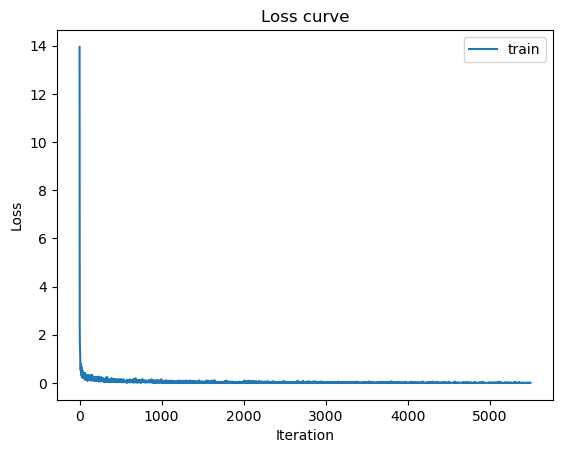

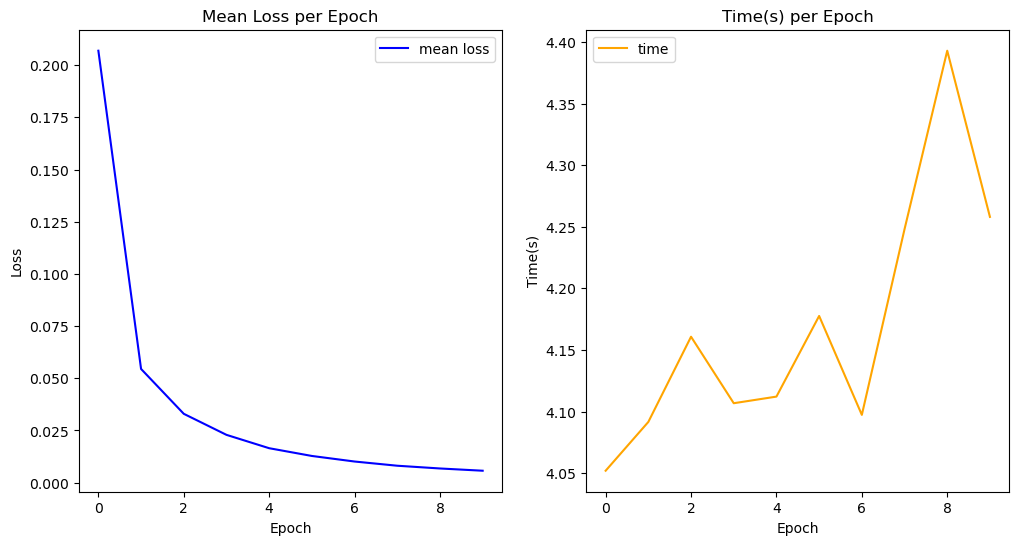

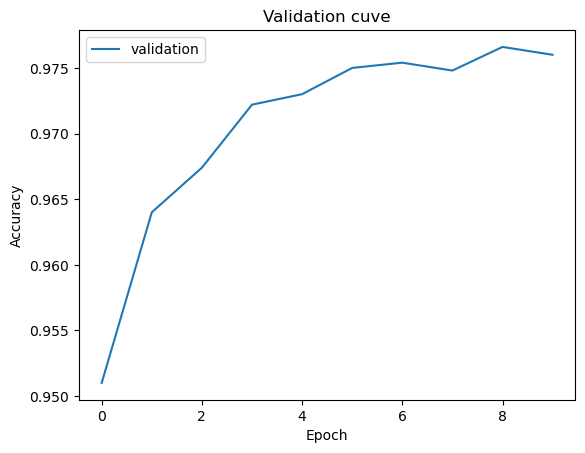

In [21]:
plt.figure(1)
plt.plot(train_loss, label="train")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curve")

plt.figure(2, figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss, label='mean loss', color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(generate_time, label='time', color='orange')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Time(s)")
plt.title("Time(s) per Epoch")

plt.figure(3)
plt.plot(val_acc, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation cuve")

plt.show()

### 정확도

In [22]:
y_pred_test = relu_modle1(X_test, W, b)
m1_test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print("Test accuracy is {:.4%}".format(m1_test_accuracy))

Test accuracy is 97.7500%


# 
# 
# 3-layer ReLU Model (hidden 128)

### 파라미터 정의

In [23]:
eta = 5e-1 # 학습률
alpha = 1e-6  # regularization
eps = 1e-8  # AdaGrad
epoch = 20
hidden_size = 128
input_size = 784
output_size = 10
batch_size = 100

### 가중치 및 편향 정규분포 내 랜덤 생성(초기화)

In [24]:
W = [1e-1*np.random.randn(input_size, hidden_size), 1e-1*np.random.randn(hidden_size, output_size)]
b = [np.random.randn(hidden_size)]

### 가중치, 편향 확인

In [25]:
print("(입력층, 은닉층) 노드 :", W[0].shape, ", (은닉층, 출력층) 노드 :", W[1].shape)
print("은닉층 편향 노드 : ", b[0].shape)

(입력층, 은닉층) 노드 : (784, 128) , (은닉층, 출력층) 노드 : (128, 10)
은닉층 편향 노드 :  (128,)


### 학습 진행
$
h=h+\frac{\partial L}{\partial W)}*\frac{\partial L}{\partial W}
$
$
\\W=W-\eta\frac{1}{\sqrt h}\frac{\partial L}{\partial W}
$

In [26]:
gW0 = gW1 = gb0 = 1 # 초기 기울기값 초기화

# 초기화
train_loss = [] # 학습 loss를 담을 리스트
val_acc = [] # validation 정확도를 담을 리스트
generate_time = [] # 시간을 담을 리스트
epoch_loss = [] # epoch 평균 에러를 담을 리스트

patience = 3         # early stopping을 위한 변수
best_val_loss = 1e9  # 최소 validation loss를 저장하기 위한 변수

for epoch in range(epoch):
    start_time = time.time()  # 현재 시간 측정
    # 미니배치 선택
    batch_indices = np.random.choice(len(X_train_batches), size=len(X_train_batches), replace=False)
    X_batch = X_train_batches[batch_indices]
    y_batch = y_train_batches[batch_indices]
    for _, (x, y) in enumerate(zip(X_batch, y_batch)):
        dW, db = backprop(W,b,x,y,alpha)

        # AdaGrad
        gW0 += dW[0] ** 2
        W[0] -= (eta / np.sqrt(gW0 + eps)) * dW[0]

        gW1 += dW[1] ** 2
        W[1] -= (eta / np.sqrt(gW1 + eps)) * dW[1]

        gb0 += db[0] ** 2
        b[0] -= (eta / np.sqrt(gb0 + eps)) * db[0]
        
        y_batch_pred = relu_modle1(x, W, b) # 학습된 가중치와 편향으로 순전파
        y_batch_loss = loss(y_batch_pred, y) # CrossEntropy loss 계산
        train_loss.append(y_batch_loss)
    
    end_time = time.time()  # 학습 종료 시간 측정
    elapsed_time = end_time - start_time  # 학습에 걸린 시간 계산
    generate_time.append(elapsed_time)
    
    minimum_loss = min(train_loss[epoch*550:(epoch+1)*550-1]) # epoch 당 최소오차
    mean_loss = sum(train_loss[epoch*550:(epoch+1)*550-1])/550
    epoch_loss.append(mean_loss)
    
    y_val_pred = relu_modle1(X_validation,W,b) # Validation 순전파
    val_loss = loss(y_val_pred,y_validation) # Validation CrossEntropy Loss 계산
    val_accuaracy = np.mean(np.argmax(y_val_pred, axis=1)== y_validation) # validaion 정확도 계산
    val_acc.append(val_accuaracy)
    
    # Early stopping
    if val_loss < best_val_loss:    # validation loss가 감소하면
        best_val_loss = val_loss    # best_val_loss를 갱신
        patience = 3                    # patience를 초기화
    else:                   # validation loss가 감소하지 않으면
        patience -= 1       # patience를 1 감소
        if patience == 0:   # patience가 0이 되면 학습 종료
            print("Early stopping")
            print("Training Time : {:.2}s".format(generate_time[-1]))
            break
    
    # 출력
    print("Training Time : {:.2}s".format(generate_time[-1]))
    print(epoch+1, "Epoch Minimum Train Cross-entropy loss : {:.8}".format(minimum_loss))
    print("Validation accuracy : {:.4%}".format(val_accuaracy))
    print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}".format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

y_pred_final = relu_modle1(X_validation,W,b)
print("Tortal Training Time : {:.3}s".format(sum(generate_time)))
print("Final cross-entropy loss : {:.8}".format(loss(y_pred_final,y_validation)))
print("Final training accuracy : {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_validation)))
print("Final |dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}".format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")

Training Time : 1.5s
1 Epoch Minimum Train Cross-entropy loss : 0.030402454
Validation accuracy : 95.1600%
|dW0|=0.45704 |dW1|=0.27931 |db0|=0.05496 

Training Time : 1.5s
2 Epoch Minimum Train Cross-entropy loss : 0.016618172
Validation accuracy : 95.7600%
|dW0|=0.42485 |dW1|=0.21452 |db0|=0.04092 

Training Time : 1.4s
3 Epoch Minimum Train Cross-entropy loss : 0.0096155476
Validation accuracy : 96.7000%
|dW0|=0.26972 |dW1|=0.12902 |db0|=0.02978 

Training Time : 1.4s
4 Epoch Minimum Train Cross-entropy loss : 0.0067491006
Validation accuracy : 96.8800%
|dW0|=0.12415 |dW1|=0.07580 |db0|=0.01366 

Training Time : 1.5s
5 Epoch Minimum Train Cross-entropy loss : 0.0056879827
Validation accuracy : 97.0400%
|dW0|=0.35509 |dW1|=0.22889 |db0|=0.03589 

Training Time : 1.4s
6 Epoch Minimum Train Cross-entropy loss : 0.0036848773
Validation accuracy : 97.1600%
|dW0|=0.35664 |dW1|=0.17257 |db0|=0.04613 

Training Time : 1.4s
7 Epoch Minimum Train Cross-entropy loss : 0.0033144652
Validation ac

### 시각화

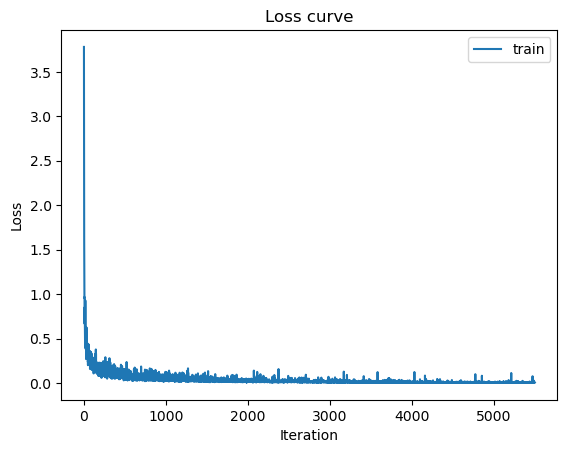

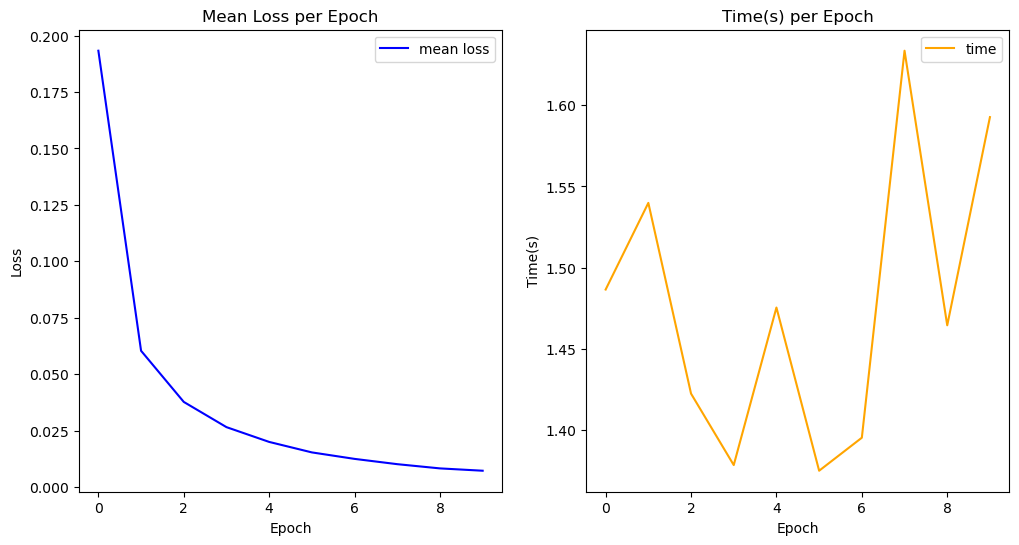

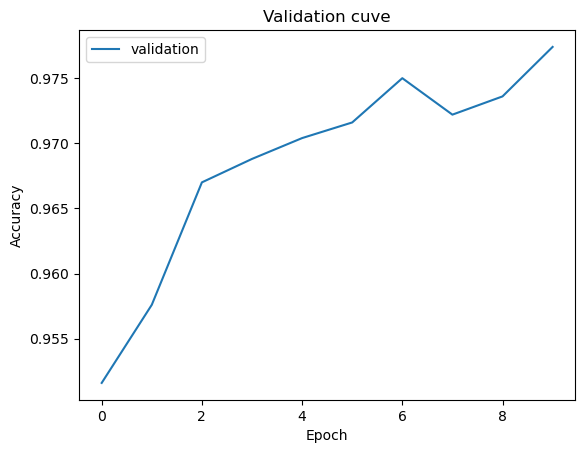

In [27]:
plt.figure(1)
plt.plot(train_loss, label="train")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curve")

plt.figure(2, figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss, label='mean loss', color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(generate_time, label='time', color='orange')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Time(s)")
plt.title("Time(s) per Epoch")

plt.figure(3)
plt.plot(val_acc, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation cuve")

plt.show()

### 정확도

In [28]:
y_pred_test = relu_modle1(X_test, W, b)
m2_test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print("Test accuracy is {:.4%}".format(m2_test_accuracy))

Test accuracy is 97.7600%


# 
# 
# 4-layer ReLU Model(128-256)
- 입력층(h) -> 은닉층1(i) -> 은닉층2(j) -> 출력층(k)

In [29]:
def relu_modle2(X,W,b):
    # 입력층
    a1 = X
    z1 = np.matmul(X, W[0]) + b[0] # W[0]는 입력층과 은닉층 사이의 가중치 및 노드, b[0]는 은닉층1 편향
    
    # 은닉층 1
    a2 = relu(z1)
    z2 = np.matmul(a2, W[1]) + b[1] # W[1]은 은닉층1과 은닉층2 사이의 가중치 및 노드, b[1]는 은닉층2 편향
    
    # 은닉층 2
    a3 = relu(z2)
    z3 = np.matmul(a3, W[2]) # W[2]은 은닉층2과 출력층 사이의 가중치 및 노드
    
    # 출력층 - SoftMax 함수 수행
    s = np.exp(z3)
    total = np.sum(s, axis=1).reshape(-1,1)
    y_hat = s/total

    return y_hat

## 4-layer ReLu Model Error Backpropergation

### 출력층과 은닉층2의 연결강도 갱신(Jacobian matrix)
$
\Delta W_{kj}(n+1)=\eta \delta_{pk}O_{pj}+\alpha \Delta W_{kj}(n)
$
### 은닉층2와 은닉층1의 연결강도 갱신
$
\Delta W_{ji}(n+1)=\eta \delta_{pj}O_{pi}+\alpha \Delta W_{ji}(n)
$
### 은닉층1과 입력층의 연결강도 갱신
$
\Delta W_{ih}(n+1)=\eta \delta_{pi}O_{ph}+\alpha \Delta W_{ih}(n)
$

In [30]:
def backprop(W,b,X,y,alpha=1e-4):
    # 입력층
    a1 = X # O ph
    z1 = np.matmul(X, W[0]) + b[0]
    
    # 은닉층 1
    a2 = relu(z1) # O pi
    z2 = np.matmul(a2, W[1]) + b[1]
    
    # 은닉층 2
    a3 = relu(z2) # O pj
    z3 = np.matmul(a3, W[2])
    
    # 출력층 - SoftMax 함수 수행
    s = np.exp(z3)
    total = np.sum(s, axis=1).reshape(-1,1)
    y_hat = s/total

    y_one_hot_vec = (y[:,np.newaxis] == np.arange(10)) # 출력 원-핫 인코딩
    delta3 = (y_hat - y_one_hot_vec) # CorssEntropy 계층과 SoftMax 계층의 역전파로 delta pk에 해당
    grad_W2 = np.matmul(a3.T, delta3) # O pj와 delta pk의 행렬곱
    
    delta2 = np.matmul(delta3, W[2].T)*(z2>0) # relu계층 역전파, 0보다 큰 값들의 index만 True가 되어 계산된다
    grad_W1 = np.matmul(a2.T, delta2) # O pi와 delta pj의 행렬곱
    
    delta1 = np.matmul(delta2, W[1].T)*(z1>0) # relu계층 역전파, 0보다 큰 값들의 index만 True가 되어 계산된다
    grad_W0 = np.matmul(X.T, delta1) # O ph와0 delta pi의 행렬곱
    
    n = X.shape[0] # 배치 사이즈 크기
    # 기울기 업데이트, 평균을 주어 미니배치 불안전성 극복 및 학습속도 유지
    dW = [grad_W0/n + alpha*W[0], grad_W1/n + alpha*W[1], grad_W2/n + alpha*W[2]]
    db = [np.mean(delta1, axis=0), np.mean(delta2, axis=0)] # 편향 업데이트

    return dW, db

### 파라미터 정의

In [31]:
eta = 5e-1 # 학습률
alpha = 1e-6  # regularization
eps = 1e-8  # AdaGrad
epoch = 20
hidden1_size = 128
hidden2_size = 256
input_size = 784
output_size = 10
batch_size = 100

### 가중치 및 편향 정규분포 내 랜덤 생성(초기화)

In [32]:
W = [1e-1*np.random.randn(input_size, hidden1_size), 1e-1*np.random.randn(hidden1_size, hidden2_size), 
     1e-1*np.random.randn(hidden2_size, output_size)]
b = [np.random.randn(hidden1_size), np.random.randn(hidden2_size)]

### 가중치, 편향 확인

In [33]:
print("(입력층, 은닉층) 노드 :", W[0].shape, ", (은닉층1, 은닉층2) 노드 :", W[1].shape, ", (은닉층2, 출력층) 노드 :", W[2].shape)
print("은닉층1 편향 노드 : ", b[0].shape, ", 은닉층2 편향 노드 : ", b[1].shape)

(입력층, 은닉층) 노드 : (784, 128) , (은닉층1, 은닉층2) 노드 : (128, 256) , (은닉층2, 출력층) 노드 : (256, 10)
은닉층1 편향 노드 :  (128,) , 은닉층2 편향 노드 :  (256,)


### 학습 진행
$
h=h+\frac{\partial L}{\partial W)}*\frac{\partial L}{\partial W}
$
$
\\W=W-\eta\frac{1}{\sqrt h}\frac{\partial L}{\partial W}
$

In [34]:
gW0 = gW1 = gW2 = gb0 = gb1 = 1 # 초기 기울기값 초기화

train_loss = [] # 학습 loss를 담을 리스트
val_acc = [] # validation 정확도를 담을 리스트
generate_time = [] # 시간을 담을 리스트
epoch_loss = [] # epoch 평균 에러를 담을 리스트

patience = 3         # early stopping을 위한 변수
best_val_loss = 1e9  # 최소 validation loss를 저장하기 위한 변수

for epoch in range(epoch):
    start_time = time.time()  # 현재 시간 측정
    # 미니배치 선택
    batch_indices = np.random.choice(len(X_train_batches), size=len(X_train_batches), replace=False)
    X_batch = X_train_batches[batch_indices]
    y_batch = y_train_batches[batch_indices]
    for _, (x, y) in enumerate(zip(X_batch, y_batch)):
        dW, db = backprop(W,b,x,y,alpha)

        # AdaGrad
        gW0 += dW[0] ** 2
        W[0] -= (eta / np.sqrt(gW0 + eps)) * dW[0]

        gW1 += dW[1] ** 2
        W[1] -= (eta / np.sqrt(gW1 + eps)) * dW[1]
        
        gW2 += dW[2] ** 2
        W[2] -= (eta / np.sqrt(gW2 + eps)) * dW[2]

        gb0 += db[0] ** 2
        b[0] -= (eta / np.sqrt(gb0 + eps)) * db[0]
        
        gb1 += db[1] ** 2
        b[1] -= (eta / np.sqrt(gb1 + eps)) * db[1]
        
        y_batch_pred = relu_modle2(x, W, b) # 학습된 가중치와 편향으로 순전파
        y_batch_loss = loss(y_batch_pred, y) # CrossEntropy loss 계산
        train_loss.append(y_batch_loss)
    
    end_time = time.time()  # 학습 종료 시간 측정
    elapsed_time = end_time - start_time  # 학습에 걸린 시간 계산
    generate_time.append(elapsed_time)
    
    minimum_loss = min(train_loss[epoch*550:(epoch+1)*550-1]) # epoch 당 최소오차
    mean_loss = sum(train_loss[epoch*550:(epoch+1)*550-1])/550
    epoch_loss.append(mean_loss)
    
    y_val_pred = relu_modle2(X_validation,W,b) # Validation 순전파
    val_loss = loss(y_val_pred,y_validation) # Validation CrossEntropy Loss 계산
    val_accuaracy = np.mean(np.argmax(y_val_pred, axis=1)== y_validation) # validaion 정확도 계산
    val_acc.append(val_accuaracy)
    
    # Early stopping
    if val_loss < best_val_loss:    # validation loss가 감소하면
        best_val_loss = val_loss    # best_val_loss를 갱신
        patience = 3                    # patience를 초기화
    else:                   # validation loss가 감소하지 않으면
        patience -= 1       # patience를 1 감소
        if patience == 0:   # patience가 0이 되면 학습 종료
            print("Early stopping")
            print("Training Time : {:.2}s".format(generate_time[-1]))
            break
    
    # 출력
    print("Training Time : {:.2}s".format(generate_time[-1]))
    print(epoch+1, "Epoch Minimum Train Cross-entropy loss : {:.8}".format(minimum_loss))
    print("Validation accuracy : {:.4%}".format(val_accuaracy))
    print("|dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f} |db1|={:.5f}".
          format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), 
                 np.linalg.norm(dW[2]), np.linalg.norm(db[0]), np.linalg.norm(db[1])), "\n")

y_pred_final = relu_modle2(X_validation,W,b)
print("Tortal Training Time : {:.3}s".format(sum(generate_time)))
print("Final cross-entropy loss : {:.8}".format(loss(y_pred_final,y_validation)))
print("Final training accuracy : {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_validation)))
print("Final |dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f} |db1|={:.5f}".
          format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), 
                 np.linalg.norm(dW[2]), np.linalg.norm(db[0]), np.linalg.norm(db[1])), "\n")

Training Time : 2.2s
1 Epoch Minimum Train Cross-entropy loss : 0.018604223
Validation accuracy : 95.0600%
|dW0|=0.30896 |dW1|=0.24211 |dW2|=0.13319 |db0|=0.04601 |db1|=0.03528 

Training Time : 2.1s
2 Epoch Minimum Train Cross-entropy loss : 0.0090599744
Validation accuracy : 96.4200%
|dW0|=0.49484 |dW1|=0.28603 |dW2|=0.15632 |db0|=0.06570 |db1|=0.04673 

Training Time : 2.1s
3 Epoch Minimum Train Cross-entropy loss : 0.0060386102
Validation accuracy : 96.8200%
|dW0|=0.32097 |dW1|=0.21727 |dW2|=0.12542 |db0|=0.03404 |db1|=0.02124 

Training Time : 2.1s
4 Epoch Minimum Train Cross-entropy loss : 0.0031138046
Validation accuracy : 97.0400%
|dW0|=0.18369 |dW1|=0.16028 |dW2|=0.08033 |db0|=0.02054 |db1|=0.01532 

Training Time : 2.2s
5 Epoch Minimum Train Cross-entropy loss : 0.0024171653
Validation accuracy : 96.1600%
|dW0|=0.54330 |dW1|=0.45061 |dW2|=0.25919 |db0|=0.05903 |db1|=0.04119 

Training Time : 2.5s
6 Epoch Minimum Train Cross-entropy loss : 0.001397126
Validation accuracy : 96.

### 시각화

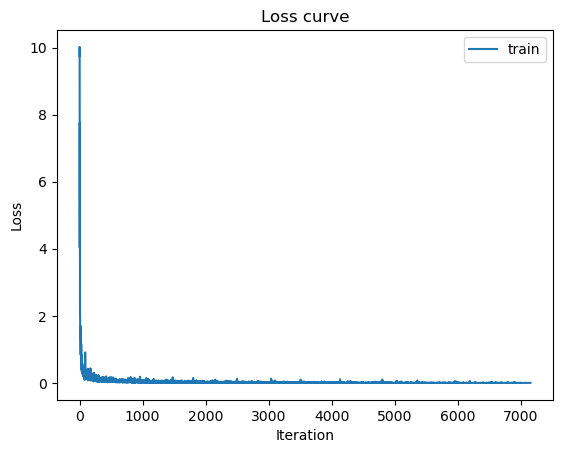

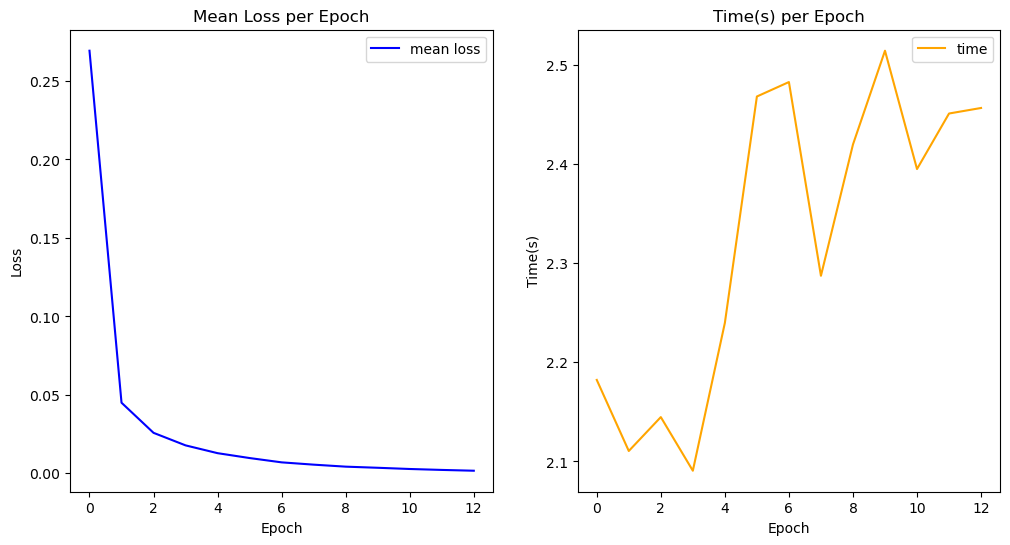

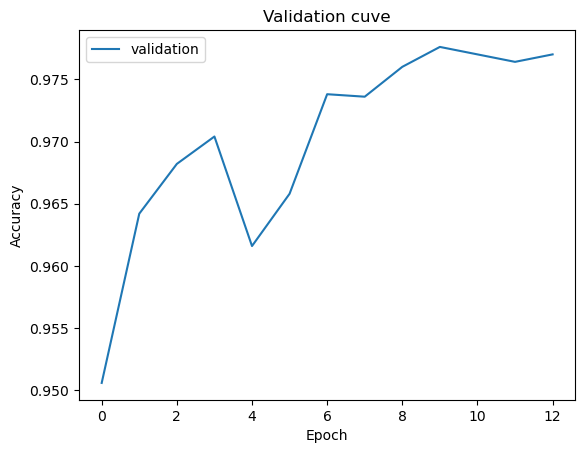

In [35]:
plt.figure(1)
plt.plot(train_loss, label="train")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curve")

plt.figure(2, figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss, label='mean loss', color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(generate_time, label='time', color='orange')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Time(s)")
plt.title("Time(s) per Epoch")

plt.figure(3)
plt.plot(val_acc, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation cuve")

plt.show()

### 정확도

In [36]:
y_pred_test = relu_modle2(X_test, W, b)
m3_test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print("Test accuracy is {:.4%}".format(m3_test_accuracy))

Test accuracy is 97.6200%


# 
# 
# 4-layer ReLU Model(50-100)
- 입력층(h) -> 은닉층1(i) -> 은닉층2(j) -> 출력층(k)

### 파라미터 정의

In [37]:
eta = 5e-1 # 학습률
alpha = 1e-6  # regularization
eps = 1e-8  # AdaGrad
epoch = 20
hidden1_size = 50
hidden2_size = 100
input_size = 784
output_size = 10
batch_size = 100

### 가중치 및 편향 정규분포 내 랜덤 생성(초기화)

In [38]:
W = [1e-1*np.random.randn(input_size, hidden1_size), 1e-1*np.random.randn(hidden1_size, hidden2_size), 
     1e-1*np.random.randn(hidden2_size, output_size)]
b = [np.random.randn(hidden1_size), np.random.randn(hidden2_size)]

### 가중치, 편향 확인

In [39]:
print("(입력층, 은닉층) 노드 :", W[0].shape, ", (은닉층1, 은닉층2) 노드 :", W[1].shape, ", (은닉층2, 출력층) 노드 :", W[2].shape)
print("은닉층1 편향 노드 : ", b[0].shape, ", 은닉층2 편향 노드 : ", b[1].shape)

(입력층, 은닉층) 노드 : (784, 50) , (은닉층1, 은닉층2) 노드 : (50, 100) , (은닉층2, 출력층) 노드 : (100, 10)
은닉층1 편향 노드 :  (50,) , 은닉층2 편향 노드 :  (100,)


### 학습 진행
$
h=h+\frac{\partial L}{\partial W)}*\frac{\partial L}{\partial W}
$
$
\\W=W-\eta\frac{1}{\sqrt h}\frac{\partial L}{\partial W}
$

In [40]:
gW0 = gW1 = gW2 = gb0 = gb1 = 1 # 초기 기울기값 초기화

train_loss = [] # 학습 loss를 담을 리스트
val_acc = [] # validation 정확도를 담을 리스트
generate_time = [] # 시간을 담을 리스트
epoch_loss = [] # epoch 평균 에러를 담을 리스트

patience = 3         # early stopping을 위한 변수
best_val_loss = 1e9  # 최소 validation loss를 저장하기 위한 변수

for epoch in range(epoch):
    start_time = time.time()  # 현재 시간 측정
    # 미니배치 선택
    batch_indices = np.random.choice(len(X_train_batches), size=len(X_train_batches), replace=False)
    X_batch = X_train_batches[batch_indices]
    y_batch = y_train_batches[batch_indices]
    for _, (x, y) in enumerate(zip(X_batch, y_batch)):
        dW, db = backprop(W,b,x,y,alpha)

        # AdaGrad
        gW0 += dW[0] ** 2
        W[0] -= (eta / np.sqrt(gW0 + eps)) * dW[0]

        gW1 += dW[1] ** 2
        W[1] -= (eta / np.sqrt(gW1 + eps)) * dW[1]
        
        gW2 += dW[2] ** 2
        W[2] -= (eta / np.sqrt(gW2 + eps)) * dW[2]

        gb0 += db[0] ** 2
        b[0] -= (eta / np.sqrt(gb0 + eps)) * db[0]
        
        gb1 += db[1] ** 2
        b[1] -= (eta / np.sqrt(gb1 + eps)) * db[1]
        
        y_batch_pred = relu_modle2(x, W, b) # 학습된 가중치와 편향으로 순전파
        y_batch_loss = loss(y_batch_pred, y) # CrossEntropy loss 계산
        train_loss.append(y_batch_loss)
    
    end_time = time.time()  # 학습 종료 시간 측정
    elapsed_time = end_time - start_time  # 학습에 걸린 시간 계산
    generate_time.append(elapsed_time)
    
    minimum_loss = min(train_loss[epoch*550:(epoch+1)*550-1]) # epoch 당 최소오차
    mean_loss = sum(train_loss[epoch*550:(epoch+1)*550-1])/550
    epoch_loss.append(mean_loss)
    
    y_val_pred = relu_modle2(X_validation,W,b) # Validation 순전파
    val_loss = loss(y_val_pred,y_validation) # Validation CrossEntropy Loss 계산
    val_accuaracy = np.mean(np.argmax(y_val_pred, axis=1)== y_validation) # validaion 정확도 계산
    val_acc.append(val_accuaracy)
    
    # Early stopping
    if val_loss < best_val_loss:    # validation loss가 감소하면
        best_val_loss = val_loss    # best_val_loss를 갱신
        patience = 3                    # patience를 초기화
    else:                   # validation loss가 감소하지 않으면
        patience -= 1       # patience를 1 감소
        if patience == 0:   # patience가 0이 되면 학습 종료
            print("Early stopping")
            print("Training Time : {:.2}s".format(generate_time[-1]))
            break
    
    # 출력
    print("Training Time : {:.2}s".format(generate_time[-1]))
    print(epoch+1, "Epoch Minimum Train Cross-entropy loss : {:.8}".format(minimum_loss))
    print("Validation accuracy : {:.4%}".format(val_accuaracy))
    print("|dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f} |db1|={:.5f}".
          format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), 
                 np.linalg.norm(dW[2]), np.linalg.norm(db[0]), np.linalg.norm(db[1])), "\n")

y_pred_final = relu_modle2(X_validation,W,b)
print("Tortal Training Time : {:.2}s".format(sum(generate_time)))
print("Final cross-entropy loss : {:.8}".format(loss(y_pred_final,y_validation)))
print("Final training accuracy : {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_validation)))
print("Final |dW0|={:.5f} |dW1|={:.5f} |dW2|={:.5f} |db0|={:.5f} |db1|={:.5f}".
          format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), 
                 np.linalg.norm(dW[2]), np.linalg.norm(db[0]), np.linalg.norm(db[1])), "\n")

Training Time : 0.83s
1 Epoch Minimum Train Cross-entropy loss : 0.024122964
Validation accuracy : 95.4400%
|dW0|=0.49494 |dW1|=0.26748 |dW2|=0.22011 |db0|=0.05403 |db1|=0.04046 

Training Time : 0.96s
2 Epoch Minimum Train Cross-entropy loss : 0.012144593
Validation accuracy : 96.0200%
|dW0|=0.37825 |dW1|=0.28182 |dW2|=0.16421 |db0|=0.03562 |db1|=0.02889 

Training Time : 0.89s
3 Epoch Minimum Train Cross-entropy loss : 0.0068744542
Validation accuracy : 96.6400%
|dW0|=0.15193 |dW1|=0.10251 |dW2|=0.07157 |db0|=0.01505 |db1|=0.01254 

Training Time : 0.94s
4 Epoch Minimum Train Cross-entropy loss : 0.0049918216
Validation accuracy : 96.5200%
|dW0|=0.66252 |dW1|=0.44957 |dW2|=0.23744 |db0|=0.07704 |db1|=0.04436 

Training Time : 0.88s
5 Epoch Minimum Train Cross-entropy loss : 0.0038916843
Validation accuracy : 96.8800%
|dW0|=0.32306 |dW1|=0.30101 |dW2|=0.24626 |db0|=0.04517 |db1|=0.03858 

Training Time : 1.0s
6 Epoch Minimum Train Cross-entropy loss : 0.0021794124
Validation accuracy 

### 시각화

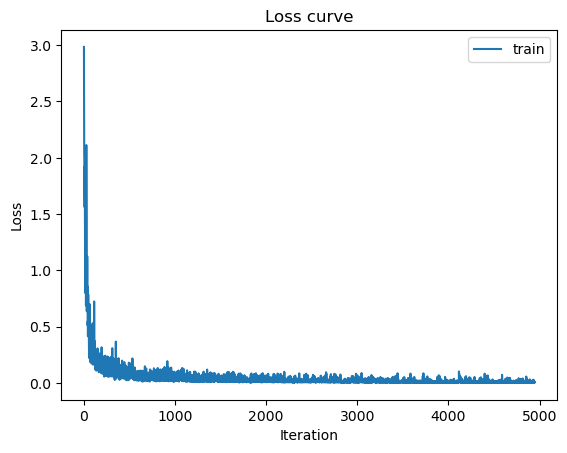

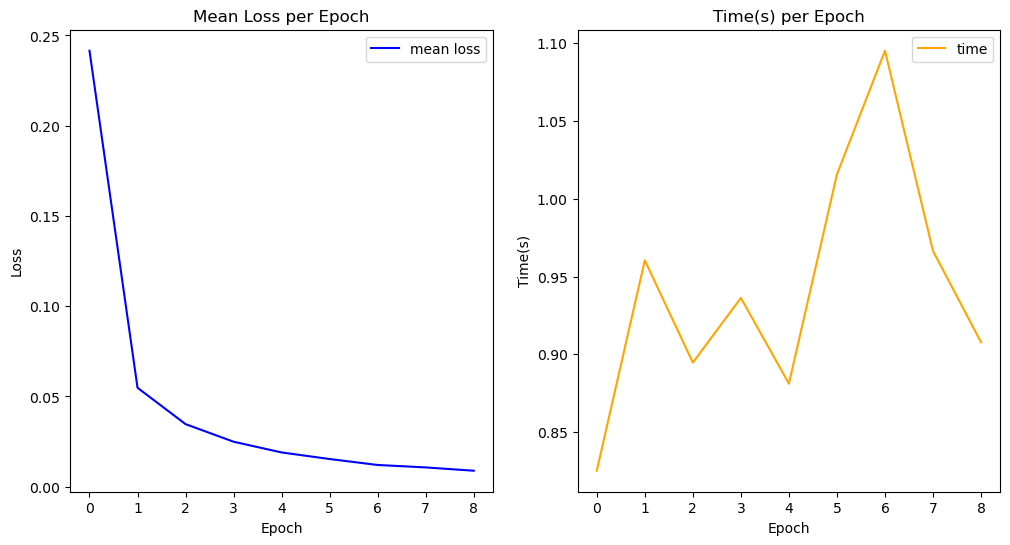

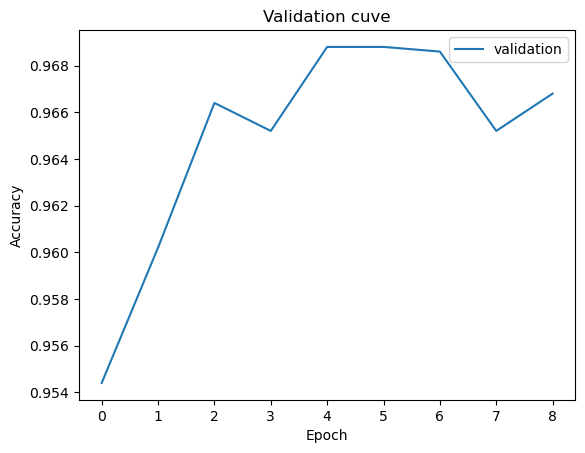

In [41]:
plt.figure(1)
plt.plot(train_loss, label="train")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss curve")

plt.figure(2, figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss, label='mean loss', color='blue')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean Loss per Epoch")

plt.subplot(1, 2, 2)
plt.plot(generate_time, label='time', color='orange')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Time(s)")
plt.title("Time(s) per Epoch")

plt.figure(3)
plt.plot(val_acc, label="validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation cuve")

plt.show()

### 정확도

In [42]:
y_pred_test = relu_modle2(X_test, W, b)
m4_test_accuracy = np.mean(np.argmax(y_pred_test, axis=1) == y_test)
print("Test accuracy is {:.4%}".format(m4_test_accuracy))

Test accuracy is 96.9000%


# 
# 
# 정확도 분석

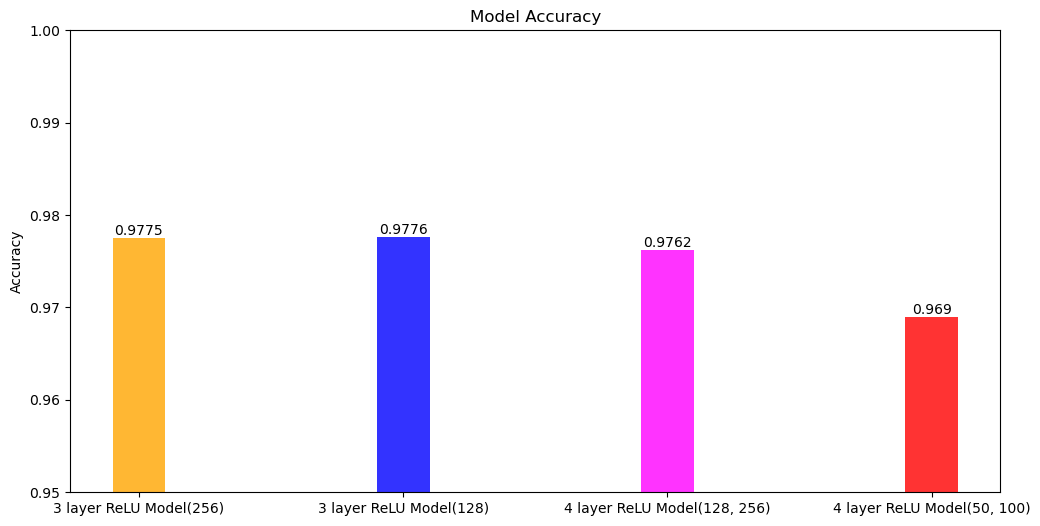

In [43]:
colors = ['orange', 'blue', 'magenta', 'red']

plt.figure(figsize=(12,6))
plt.bar([0, 1, 2, 3], [m1_test_accuracy, m2_test_accuracy, m3_test_accuracy, m4_test_accuracy],
        width=0.2, tick_label=["3 layer ReLU Model(256)", "3 layer ReLU Model(128)", 
                               "4 layer ReLU Model(128, 256)", "4 layer ReLU Model(50, 100)"], 
        color=colors, alpha=0.8)
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.ylim(0.95, 1.00)

# 막대 그래프 위에 값을 표시
for i, j in enumerate([m1_test_accuracy, m2_test_accuracy, m3_test_accuracy, m4_test_accuracy]):
    plt.text(i, j, str(j), ha='center', va='bottom')

plt.show()